<a href="https://colab.research.google.com/github/O-Kpy/Project/blob/main/%EC%84%9C%EC%9A%B8%EC%8B%9C_%EB%B3%91%EC%9D%98%EC%9B%90_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.map import *
from folium.plugins import HeatMap

In [ ]:
!apt-get update -qq  ## 나눔 설치
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 160815 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
import matplotlib as mpl
import matplotlib.font_manager as fm   ## 폰트 매니저
fontpath = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' 
font = fm.FontProperties(fname=fontpath, size=9).get_name()
plt.rc('font', family=font) 
mpl.font_manager._rebuild()

# 데이터 불러오기

In [102]:
data = pd.read_csv('/content/drive/MyDrive/dataset/공공데이터/서울특별시 병의원 위치 정보.csv', encoding='cp949')

In [19]:
data.head()

,기관ID,주소,병원분류,병원분류명,응급의료기관코드,응급의료기관코드명,응급실운영여부(1/2),비고,기관설명상세,간이약도,기관명,대표전화1,응급실전화,진료시간(월요일)C,진료시간(화요일)C,진료시간(수요일)C,진료시간(목요일)C,진료시간(금요일)C,진료시간(토요일)C,진료시간(일요일)C,진료시간(공휴일)C,진료시간(월요일)S,진료시간(화요일)S,진료시간(수요일)S,진료시간(목요일)S,진료시간(금요일)S,진료시간(토요일)S,진료시간(일요일)S,진료시간(공휴일)S,우편번호1,우편번호2,병원경도,병원위도,작업시간
0,A1104130,서울특별시 강남구 도산대로 118 (논현동 신사빌딩 2층),C,의원,G099,응급의료기관 이외,2,비만클리닉,365일 진료 국민건강보험공단 검진 지정병원 점심시간 13~14시,신사역 1번 출구 인근,365엠씨의원,02-516-3650,02-920-5374,2000,2000,1900,2000,2000,1600,1400.0,1400.0,1100,1100,1100,1100,1100,1100,900.0,900.0,60,38,127.021809,37.516604,2021-06-07 14:54:49.0
1,B1100027,서울특별시 강남구 봉은사로 612 (삼성동),E,한방병원,G099,응급의료기관 이외,2,NaN,NaN,봉은사역 5번 출구 삼성1동주민센터 옆,(의)가산의료재단광동한방병원,02-2222-4888,NaN,1800,1800,1800,1800,1800,1500,NaN,NaN,900,900,900,900,900,900,NaN,NaN,61,70,127.062148,37.514280,2021-07-07 14:54:48.0
2,A1106309,서울특별시 영등포구 경인로 841 영등포우체국 45층 (영등포동4가),C,의원,G099,응급의료기관 이외,2,수액처치/소아(8세이상)/x-ray/혈액검사/심전도/인공신장실/,의료법인 열린의료재단,연신내역 3번 출구 연신내메디컬센터,(의)열린의료재단영등포열린의원,02-2676-0832,NaN,1800,1300,1800,1300,1800,1300,1230.0,1230.0,900,900,900,900,900,900,900.0,900.0,73,5,126.908759,37.518881,2021-07-07 14:54:48.0
3,A1116513,서울특별시 용산구 유엔빌리지길 72 지하1지상12층 (한남동),C,의원,G099,응급의료기관 이외,2,2013.10 개업,평일야간진료는 예약제/토요일 한달에 한번 휴무이나 유동적이므로 토요일 진료시 미리전화/,교대역 8번 출구,97.7비엔에치의원,02-3438-0510,02-920-5374,1830,1830,1830,1830,1830,1600,2300.0,2300.0,930,930,930,930,930,930,900.0,900.0,44,20,127.010816,37.532189,2020-12-07 14:53:12.0
4,B1105308,서울특별시 송파구 가락로 169 (송파동2층),G,한의원,G099,응급의료기관 이외,2,X-ray/초음파/봉합/물리치료,심장관련 클리닉 운영/,수유역 4번 출구,S앤비한의원,02-3432-7585,02-920-5374,1800,2100,1830,2100,2100,1400,2300.0,2300.0,1000,1000,1400,1000,1000,1000,900.0,900.0,56,64,127.113878,37.504060,2021-04-07 14:54:50.0


# 시각화 계획

- 병원분류명, 응급의료기관코드명, 비고, 공간 시각화(위,경도) 

- 데이터 info 시각화
 > 사용 viz = seaborn, plt.subplots(gridspec_kw==(plot의 크기를 조정 할 수 있다. (gridspec을 안써도 되네...)))



Text(0.5, 1.0, '데이터 unique 갯수')

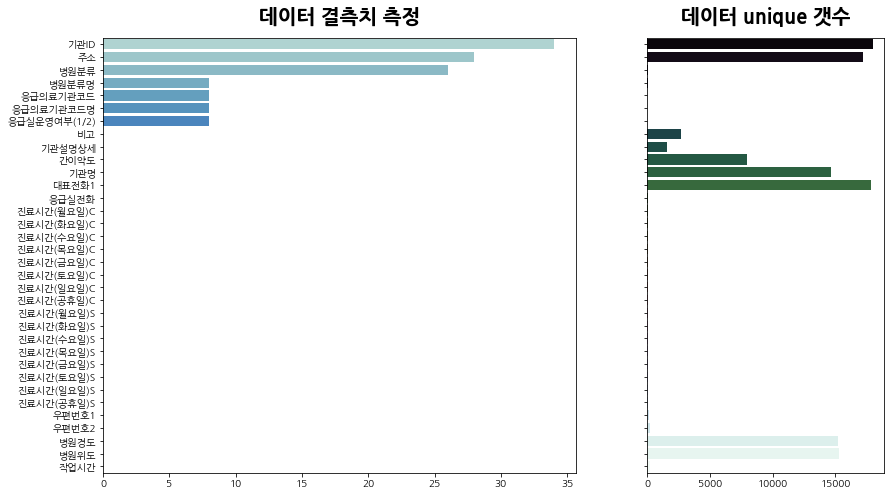

In [62]:
isnull = data.isnull().sum().sort_values(ascending=False)
nu = data.nunique()

fig, ax = plt.subplots(1, 2, figsize=(14,8), gridspec_kw={'width_ratios': [2, 1]}, sharey=True)
sns.barplot(y=isnull.index, x=isnull, palette=sns.color_palette('icefire', n_colors=len(isnull.index)), ax=ax[0])
ax[0].set_title('데이터 결측치 측정', fontsize=20, pad=15, fontweight='bold')
sns.barplot(y=nu.index , x=nu, ax=ax[1], palette=sns.color_palette('cubehelix', n_colors=len(nu.index)))
ax[1].set_title('데이터 unique 갯수', fontsize=20, pad=15, fontweight='bold')


# nlp
- 병원분류명 visualization
 > scatter, pie plot 

 > 동별로 나눠서 시각화

 > text전처리를 통해서

In [100]:
pip install konlpy

     |████████████████████████████████| 19.4MB 5.9MB/s 
     |████████████████████████████████| 450kB 44.2MB/s 
     |████████████████████████████████| 92kB 9.0MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [109]:
from gensim.models import Word2Vec, FastText
from konlpy.tag import Okt

In [103]:
data['주소'] = data['주소'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")

In [104]:
data['주소']

0            서울특별시 강남구 도산대로  논현동 신사빌딩 층
1                   서울특별시 강남구 봉은사로  삼성동
2        서울특별시 영등포구 경인로  영등포우체국 층 영등포동가
3           서울특별시 용산구 유엔빌리지길  지하지상층 한남동
4                   서울특별시 송파구 가락로  송파동층
                      ...              
17980               서울특별시 강서구 곰달래로  화곡동
17981        서울특별시 용산구 한강대로  한강로가 용성비즈텔
17982       서울특별시 강남구 봉은사로  센트럴타워 층 논현동
17983         서울특별시 강서구 강서로  터보빌딩 층 화곡동
17984         서울특별시 은평구 은평로  호 응암동 상현빌딩
Name: 주소, Length: 17985, dtype: object

In [107]:
stopwords = ['호', '층']
okt = Okt()
tokenized_data = []
for sentence in data['주소']:
    temp_X = okt.morphs(sentence, stem=True)  # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
    tokenized_data.append(temp_X)

In [110]:
model = FastText(sentences=tokenized_data, size=100, window=5, min_count=5, workers=4)
model.wv.vectors.shape

(1403, 100)

In [117]:
model.wv.similar_by_word('청담동')

[('청담', 0.995995819568634),
 ('신사', 0.988386332988739),
 ('신사동', 0.9847554564476013),
 ('삼성동', 0.9846946001052856),
 ('논현동', 0.9793415069580078),
 ('논현', 0.9700166583061218),
 ('역삼동', 0.969609797000885),
 ('역삼', 0.9693395495414734),
 ('일부', 0.9682472348213196),
 ('비엘', 0.9634729623794556)]

# folium 시각화

In [129]:
data_fo = data.groupby(['병원위도', '병원경도'])['기관ID'].count().reset_index(name='Count')
data_fo

,병원위도,병원경도,Count
0,17.662356,8.450911,1
1,37.434611,126.903790,1
2,37.441348,126.903855,1
3,37.442111,126.903943,1
4,37.442250,126.903950,1
...,...,...,...
15329,37.686044,127.046822,1
15330,37.687109,127.053059,2
15331,37.687134,127.053092,1
15332,37.687167,127.045531,1


In [133]:
data_fo = data.groupby(['병원위도', '병원경도'])['기관ID'].count().reset_index(name='Count')
map = folium.Map(location=[data['병원위도'].median(), data['병원경도'].median()], zoom_start=12)
marker = HeatMap(zip(data_fo['병원위도'], data_fo['병원경도'], data_fo['Count']), max_zoom=1, radius=5 )
map.add_child(marker)